**This notebook is for classifying  between dogs and cats**

---



---
***My target is :***


1.   Increasing accuracy rate and decreasing loss rate as possible
2.   Prevent overfitting 

1.   Reach accuracy >= 95% and stop the training immediately
2.   Shorten the time of training by using transfer learning 







In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import random
import numpy as np

from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
#load premade training model to shorten the time
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-08-01 20:49:14--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.28.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  87.8MB/s    in 1.0s    

2020-08-01 20:49:15 (87.8 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-08-01 20:49:16--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.28.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   108MB/s    in 0.6s    

2020-08-01 20:49:17 (108 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
print('total training cats images:', len(os.listdir(train_cats_dir)))
print('total training dogs images:', len(os.listdir(train_dogs_dir)))
print('total validation cats images:', len(os.listdir(validation_cats_dir)))
print('total validation dogs images:', len(os.listdir(validation_dogs_dir)))

total training cats images: 1000
total training dogs images: 1000
total validation cats images: 500
total validation dogs images: 500


In [ ]:
train_cat_names = os.listdir( train_cats_dir )
train_dog_names = os.listdir( train_dogs_dir )
validation_dog_names = os.listdir( validation_cats_dir )
validation_dog_names = os.listdir( validation_dogs_dir)

print(train_cat_names[:10])
print(train_dog_names[:10])
print(validation_dog_names[:10])
print(validation_dog_names[:10])

['cat.319.jpg', 'cat.691.jpg', 'cat.530.jpg', 'cat.890.jpg', 'cat.771.jpg', 'cat.431.jpg', 'cat.519.jpg', 'cat.388.jpg', 'cat.745.jpg', 'cat.494.jpg']
['dog.790.jpg', 'dog.269.jpg', 'dog.424.jpg', 'dog.122.jpg', 'dog.171.jpg', 'dog.428.jpg', 'dog.187.jpg', 'dog.741.jpg', 'dog.566.jpg', 'dog.222.jpg']
['dog.2259.jpg', 'dog.2446.jpg', 'dog.2245.jpg', 'dog.2478.jpg', 'dog.2368.jpg', 'dog.2004.jpg', 'dog.2268.jpg', 'dog.2224.jpg', 'dog.2406.jpg', 'dog.2081.jpg']
['dog.2259.jpg', 'dog.2446.jpg', 'dog.2245.jpg', 'dog.2478.jpg', 'dog.2368.jpg', 'dog.2004.jpg', 'dog.2268.jpg', 'dog.2224.jpg', 'dog.2406.jpg', 'dog.2081.jpg']


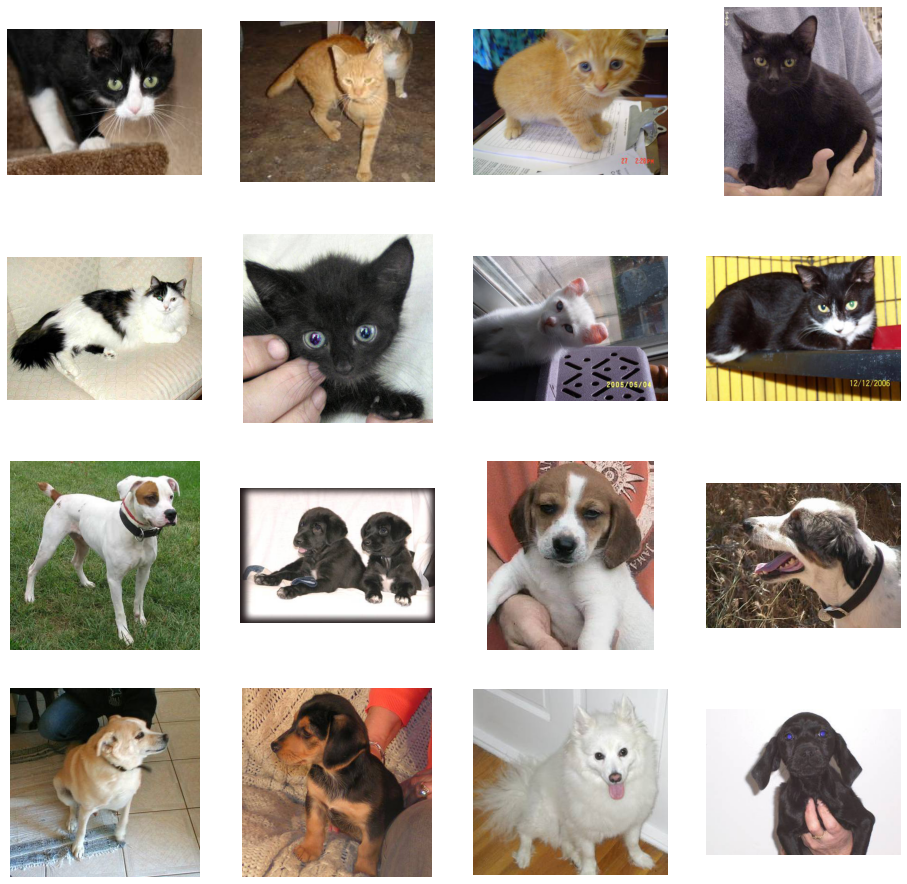

In [ ]:
nrows = 4
ncols = 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_names[pic_index-8:pic_index]]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix + next_dog_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') 
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest' 
                                   )

test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150)
                                                    )     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(
                                                        validation_dir,
                                                        batch_size=20,
                                                        class_mode  = 'binary',
                                                        target_size = (150, 150)
                                                         )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy')>.95):
                print("\nReached 95 % accuracy so cancelling training!")
                self.model.stop_training = True
callbacks = myCallback()                

In [ ]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x)

last layer output shape:  (None, 7, 7, 768)


In [ ]:
optimizer = keras.optimizers.Adam(lr=.0001)
model.compile(
                loss='binary_crossentropy',
                optimizer = optimizer,
                metrics=['accuracy']
              )

In [ ]:
history=model.fit(
                    train_generator,  
                    validation_data = validation_generator,
                    epochs=20,
                    steps_per_epoch = 100,
                    validation_steps = 50,
                    verbose = 2,
                    callbacks=[callbacks]
                  )


Epoch 1/20
100/100 - 18s - loss: 0.2653 - accuracy: 0.8795 - val_loss: 0.1871 - val_accuracy: 0.9260
Epoch 2/20
100/100 - 17s - loss: 0.1955 - accuracy: 0.9180 - val_loss: 0.1321 - val_accuracy: 0.9540
Epoch 3/20
100/100 - 17s - loss: 0.1692 - accuracy: 0.9285 - val_loss: 0.1493 - val_accuracy: 0.9490
Epoch 4/20
100/100 - 17s - loss: 0.1616 - accuracy: 0.9350 - val_loss: 0.1543 - val_accuracy: 0.9410
Epoch 5/20
100/100 - 17s - loss: 0.1586 - accuracy: 0.9340 - val_loss: 0.1268 - val_accuracy: 0.9530
Epoch 6/20
100/100 - 17s - loss: 0.1522 - accuracy: 0.9370 - val_loss: 0.1022 - val_accuracy: 0.9640
Epoch 7/20
100/100 - 17s - loss: 0.1472 - accuracy: 0.9430 - val_loss: 0.0854 - val_accuracy: 0.9640
Epoch 8/20
100/100 - 17s - loss: 0.1367 - accuracy: 0.9455 - val_loss: 0.0979 - val_accuracy: 0.9630
Epoch 9/20

Reached 95 % accuracy so cancelling training!
100/100 - 17s - loss: 0.1244 - accuracy: 0.9545 - val_loss: 0.0965 - val_accuracy: 0.9570


**This chart shows that I stopped overfitting from being occuered**

---



---



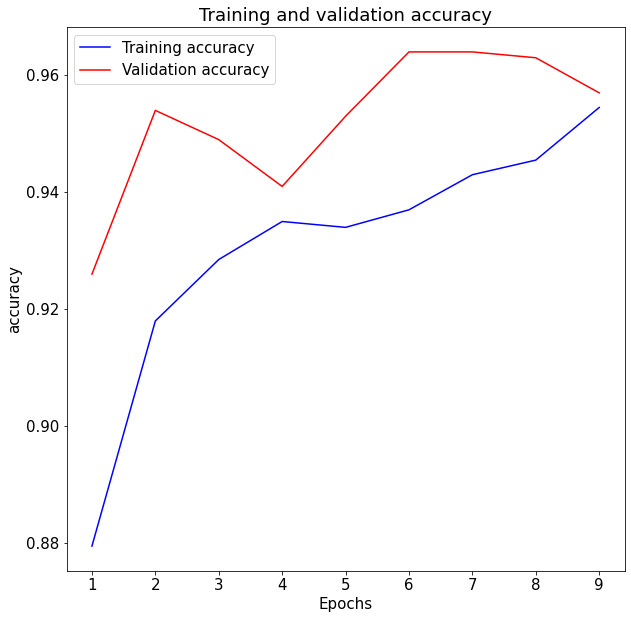

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1 , len(acc) + 1)

plt.plot(epochs , acc , 'b' , label = 'Training accuracy' )
plt.plot(epochs , val_acc, 'r' , label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

plt.legend()
plt.rc('font', size = 15)
plt.rc('figure', figsize=[10,10])
plt.show()
